
# SI 370 - Homework 6 

Version 2022.11.16

In this assignment, you'll apply your knowledge of classification to text analysis, specifically real and fake news. Your task is to predict whether a news article is real or fake using the available information.

The dataset that you'll use is described at https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
as well as the following references:

Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018.

Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

You will probably get the most informative information from the content of the articles as well as their titles.  

You have at your disposal several
techniques that you can use to create features from text, including, word embedding, part-of-speech analysis (from SI 330), and so on.  You might want to use CountVectorizer and/or TfidfVectorizer from the
sklearn.feature_extraction library, which are described below.

You should pre-process your text using at least some of the steps outlined in lectures (e.g. normalizing to lowercase, splitting into words, etc.).

The articles are provided in two different files: Fake.csv and True.csv.  We recommend that you create a dataframe with the contents of those files combined, including a new column that specifies whether the article is real or fake (note that you can use whatever coding you want for "real" vs. "fake", e.g. 1 and 0, "real" and "fake", "false" and "true" -- whatever works for you.

You should split the resulting combined dataframe into training and testing datasets OR use cross-validation.  If you go the splitting-into-training-and-testing route, we recommend an 80-20 split (i.e. training gets 80% of the data; testing gets 20%) and use the testing dataset to report your accuracy score.  If you go the cross-validation route, we recommend using 5-fold cross-validation and use the mean accuracy score for your 5 folds when reporting your accuracy score.


Much like the previous homework assignment, you'll want to try a variety of classifiers and possibly use an ensemble.  And, in a similar way to the previous homework assignment, your submission (to Canvas -- there is no requirement to submit this anywhere else, including Kaggle) should be based on a Jupyter notebook that you create.

Points will be allocated as follows:

| Component | Points |
|:---|:---|
|1. Text pre-processing and feature extraction, including justification for your choices| 8 |
|2. Use of at least three classifiers, not including VotingClassifier (if you use it) |  6  |
|3. Accuracy (based on test dataset)| 75%: 2 , 80%: 4 , 90%: 6  |

Note that you are welcome to use VotingClassifier to improve your accuracy, you just can't count it as one of the three classifiers for points in Component 2.


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

In [110]:
true = pd.read_csv('True.csv')
fake = pd.read_csv('Fake.csv')

In [111]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [112]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [113]:
print('Fake Subjects: {}'.format(fake.subject.unique()))
print('Real Subjects: {}'.format(true.subject.unique()))

Fake Subjects: ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
Real Subjects: ['politicsNews' 'worldnews']


There is the potential for data leakage if these subject columns are used in our classifiers, as the word 'News' is used by both datasets and does not provide much information in terms of determining the truth of an article. The same principle likely applies for the date column as well, so these will be removed prior to making the training and test datasets.

In [114]:
fake['Truth'] = 0
true['Truth'] = 1

In [115]:
# Merging the two datasets
news = pd.concat([true, fake], axis=0)
display(news.head())

,title,text,subject,date,Truth
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [116]:
news = news.drop(['title', 'subject', 'date'], axis=1)

In [117]:
news

,text,Truth
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...
23476,21st Century Wire says As 21WIRE reported earl...,0
23477,21st Century Wire says It s a familiar theme. ...,0
23478,Patrick Henningsen 21st Century WireRemember ...,0
23479,21st Century Wire says Al Jazeera America will...,0


The titles of these articles are also going to be removed in addition to the subject and data columns before creating our training and testing datasets. This is because, in my past experiences, titles can be misleading and potentially be hard to analyze when it comes to the truth of an article, as they are often written in such a way that users will check out the articles presented. So, the main focus of this analysis will be determining truth from the actual text of each article.

In [118]:
# Split into train & test datasets (80:20 split)
target = "Truth"

X = news['text']
y = news[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=7
                                                    )

In [119]:
X_train

15852    Poor little Al if he s not race baiting, he s ...
16604    How bad is it in Venezuela? People are eating ...
20950    Now we know the reason it took so long for any...
21359    BERLIN (Reuters) - Turkey will never be a memb...
11388    LIMA (Reuters) - The Fujimori clan is at it ag...
                               ...                        
12723     Members Of The Intelligence Committee Simply ...
13927    BRUSSELS (Reuters) - Chancellor Angela Merkel ...
919      WASHINGTON (Reuters) - A rare high-level defec...
17050    Just take this chemotherapy sweetie..the gover...
10742    LAS VEGAS/COLUMBIA, S.C. (Reuters) - Republica...
Name: text, Length: 35918, dtype: object

In [120]:
y_train

15852    0
16604    0
20950    0
21359    1
11388    1
        ..
12723    0
13927    1
919      1
17050    0
10742    1
Name: Truth, Length: 35918, dtype: int64

In [121]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True,
                                   stop_words=stopwords.words('english'),
                                   smooth_idf=False,
                                   sublinear_tf=False,
                                   norm=None,
                                   analyzer='word',
                                   max_features=10000,
                                   ngram_range=(1, 3))

X_train_vectorized = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_vectorized = tfidf_vectorizer.transform(X_test).toarray()

This TfIdf vectorizer normalizes the text and removes stopwords within the function itself. This allows for the most accurate analysis of each text, as the stop words will have likely been in both fake and true articles. This limits the potential for inaccuracies bassed on those given stop words.

In [122]:
X_train_vectorized

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [123]:
y_train.shape

(35918,)

In [124]:
names = ["Decision Tree",
         "Extra Trees",
         "Naive Bayes",
         "Random Forest",
         ]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=100, random_state=0),
    GaussianNB(),
    RandomForestClassifier(n_estimators=50,
                           random_state=42,
                           criterion='entropy',
                           max_depth=None,
                           min_samples_split=2),
    ]

In [125]:
estimators = [(name, clf) for name, clf in zip(names, classifiers)]
eclf1 = VotingClassifier(estimators=estimators, voting='hard')
eclf1 = eclf1.fit(X_train_vectorized, y_train)

In [126]:
for name, clf in zip(names, classifiers):
    clf = clf.fit(X_train_vectorized, y_train)

    # evaluate predictions
    accuracy = clf.score(X_test_vectorized, y_test)
    print("%s Accuracy: %.2f%%" % (name, accuracy * 100.0))

Decision Tree Accuracy: 99.60%
Extra Trees Accuracy: 99.68%
Naive Bayes Accuracy: 93.14%
Random Forest Accuracy: 99.87%


After using 4 classifiers to make predictions from, the most accurate classifier was the random forest, with a near perfect 99.87% accuracy. Decision trees and extra trees have a 99.60% and 99.68% accuracy respectively, while Naive Bayes has a 93.14% accuracy. This is still very good, but clearly not as strong as the other 3 classifiers utilized in this analysis.

In [127]:
eclf1

VotingClassifier(estimators=[('Decision Tree',
                              DecisionTreeClassifier(max_depth=5)),
                             ('Extra Trees',
                              ExtraTreesClassifier(random_state=0)),
                             ('Naive Bayes', GaussianNB()),
                             ('Random Forest',
                              RandomForestClassifier(criterion='entropy',
                                                     n_estimators=50,
                                                     random_state=42))])

In [128]:
predictions = eclf1.predict(X_test_vectorized)

CONFUSION MATRIX:

[[4671    4]
 [   6 4299]]


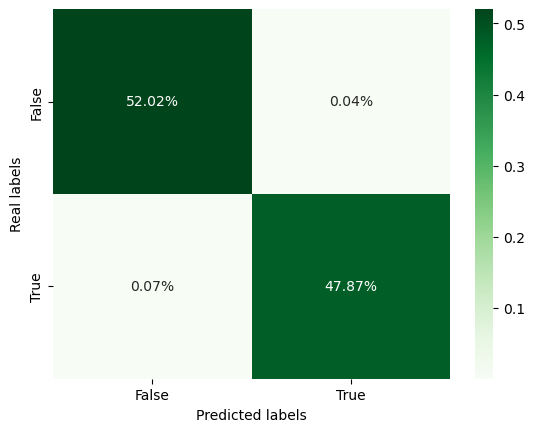

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4675
           1       1.00      1.00      1.00      4305

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [129]:
# confusion matrix
conf_mat = confusion_matrix(y_test, predictions)

print('CONFUSION MATRIX:\n\n{}'.format(conf_mat))

ax = plt.subplot()
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, ax=ax, cmap='Greens', fmt='.2%')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Real labels')
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()

# classification report
print('CLASSIFICATION REPORT:\n\n{}'.format(classification_report(
                                                y_test,
                                                predictions)))

In [130]:
# Evaluating predictions
accuracy = eclf1.score(X_test_vectorized, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.89%


From the four classifiers utilized, as well as a voting classifier to ensemble them, the final accuracy of the model when used against our test dataset is 99.89%. This is nearly perfect, and according to the confusion matrix, only 10 articles of the 8980 in the test dataset were mislabeled as either true or false. It would be interesting to now test this accuracy on an external dataset to see if the model truly works on other, new data.